<a href="https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/seq2seq_Part_D_Encoder_Decoder_with_Teacher_Forcing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART D: Encoder Decoder with Teacher Forcing
Welcome to the **Part D** of Seq2Seq Learning Tutorial Series.
In this tutorial, we will design an Encoder Decoder model to be trained with "***Teacher Forcing***" to solve the sample Seq2Seq problem introduced in **Part A**.

We will use the **LSTM** layer in Keras as the Recurrent Neural Network.

If you would like to follow up all the tutorials, please **subcribe** to [my YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists) or **follow** [my blog on Medium](https://medium.com/@kmkarakaya). Do not forget to turn on **Notifications** so that you will be notified when ***new parts are uploaded***.

You can access this **Colab Notebook** using [the link](https://colab.research.google.com/drive/1TNUB8vsZimVZl_wktWS1ac4wyw8kaNLW?usp=sharing) given in the video descriptions below.

If you are ready, let's get started!


---
# References:

**Blogs**:

* [tf.keras.layers.LSTM official website](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

* [A ten-minute introduction to sequence-to-sequence learning in Keras by Francois Chollet](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

* [How to Develop an Encoder-Decoder Model with Attention in Keras by Jason Brownlee](https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/)

**Presentations:**

* [LSTM from a programmer's perspective by Murat Karakaya Akademi](https://github.com/kmkarakaya/ML_tutorials/raw/bf15d1d5aebd23e05420c12f3c954abea9204b1f/ppt/HOW%20KERAS%20LSTM%20WORKS.pptx)

**Videos:**
* [LSTM from scratch by Murat Karakaya Akademi](https://youtu.be/7nnSjZBJVDs)

**Notebooks**:
* [LSTM intro by Murat Karakaya Akademi](https://colab.research.google.com/drive/1kG5pUczEtqdDtMHiNL-mvgTi-5-Y058t?usp=sharing)
* [Recap LSTM outputs by Murat Karakaya Akademi](https://colab.research.google.com/drive/1nUazJkXcRZi-XiXCr6sEgCy2Z5Mhze1n?usp=sharing)



---
# Preparation

In [ ]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found
time: 5.67 ms


In [ ]:
#@title Version Info
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)


tf version:  2.3.0
tf.keras version: 2.4.0
time: 4.52 ms


In [ ]:
#@title Time
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.45 s


In [ ]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

time: 13.1 ms


In [ ]:
#@title Functions to generate Seq2Seq Dataset, one hot encode / decode Input & Output Sequences


# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(0, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(time_steps, vocabulary_size)
	sequence_out = sequence_in[::-1]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))

	if(verbose):
		print('\nSample X and y')
		print('\nIn raw format:')
		print('X=%s, y=%s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))
		print('\nIn one_hot_encoded format:')
		print('X=%s' % (X[0]))
		print('y=%s' % (y[0]))
	return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nGenerated sequence datasets as follows')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, 	y_test

time: 44.4 ms


In [ ]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( one_hot_decode(X_test[0][sample]), ' ', 
					one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)
	


time: 40.6 ms


---
# SEQ2SEQ LEARNING SERIES:
* This is the **Part D** of the Seq2Seq Learning series.

* **Please check out the previous parts** to ***refresh*** the necessary background knowledge in order to follow this part with ease.

You can access all my **SEQ2SEQ Learning** videos on **[Murat Karakaya Akademi Youtube channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists?view=1&flow=grid)** in [ENGLISH](https://www.youtube.com/playlist?list=PLQflnv_s49v-4aH-xFcTykTpcyWSY4Tww) or in [TURKISH](https://www.youtube.com/playlist?list=PLQflnv_s49v97hDXtCo4mgje_SEiJ0_hH)

You can access to [my blog on Medium](https://medium.com/@kmkarakaya)

**Part A: AN INTRODUCTION TO SEQ2SEQ LEARNING AND A SAMPLE SOLUTION WITH MLP NETWORK** 
 
   * YouTube Videos in [ENGLISH](https://youtu.be/9TEPkRLhgSc) or [TURKISH](https://youtu.be/p2QlkuV4ito) / [Medium Post](https://medium.com/@kmkarakaya/part-a-introduction-to-seq2seq-learning-a-sample-solution-with-mlp-network-95dc0bcb9c83?sk=2063e3c62b1989efedf6625ac626c2ee) / [Colab Notebook](https://colab.research.google.com/drive/1fffqeeJsY89LuxsEl_7Re33nCWGusjCj?usp=sharing)

**Part B: SEQ2SEQ LEARNING WITH RECURRENT NEURAL NETWORKS (LSTM)** 

   * YouTube Video in [ENGLISH](https://youtu.be/7L5bkMu0Pgg) or [TURKISH](https://youtu.be/UA4rDcq5Cuo) / [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-b-using-lstm-layer-in-a-recurrent-neural-network-9be629bb71e2?source=friends_link&sk=0b6e0f34592100b991664c55061ca394) / [Colab Notebook](https://colab.research.google.com/drive/1DBaHgsoPJCoj8SXAqNqQtKqAtwrUc4qS?usp=sharing)


**Part C: SEQ2SEQ LEARNING WITH A BASIC ENCODER DECODER MODEL** 

   * YouTube Video in [ENGLISH](https://youtu.be/iHJkfsV9cqY) or [TURKISH](https://youtu.be/SZNqENbc9f4)/ [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-c-basic-encoder-decoder-a7f536f5f510) / [Colab Notebook](https://colab.research.google.com/drive/1ErnVEZOmlu_nInxaoLStW0BHzgT4meVj?usp=sharing)

**Part D: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + TEACHER FORCING** 

   * YouTube Video in [ENGLISH](https://youtu.be/RRP0czWtOeM) or TURKISH / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1TNUB8vsZimVZl_wktWS1ac4wyw8kaNLW?usp=sharing)

**Part E: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL FOR VARIABLE INPUT AND OUTPUT SIZE** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1DtOpSacgqJ1hDQ3GSx0BZgnQHrjwJAsy?usp=sharing)

**Part F: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + TEACHER FORCING FOR VARIABLE INPUT AND OUTPUT SIZE** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1cxDOWY7PQSx-tRy8inE2IG7-xGpVJWNP?usp=sharing)

**Part G: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + BAHDANAU ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1VFfeP3eiauYCRvW8vMvL0NRKaOtcGz3J?usp=sharing)


**Part H: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + LUONG ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1N0ycXm7Lq3jWzbJERRy6rwL1Ux4hmlWM?usp=sharing)


# WHY WE HAVE SO MANY PARTS?
* Our aim is to code an Encoder Decoder Model with Attention. 
* However, I would like to develop the solution by showing the shortcomings of other possible approaches.
* Therefore, in the first 2 parts, we will observe that initial models have their own weakness.
* We also understand why Encoder Decoder paradigm is so successful.

**So, please patiently follow the parts as we develop a better solution :)**

---

# A Simple Seq2Seq Problem: The reversed sequence problem
Assume that:
* We are given a **parallel data set** including X (input) and y (output) such that X[i] and y[i] have some relationship

<br>

In that tutorial, I will **generate** X and y parallel datasets such that **y sequence** will be  **the reverse of** the given **X sequence**. For example,

* **Given sequence** X[i] length of 4:

 X[i]=[3, 2, 9, 1]

* **Output sequence** (y[i]) is the **reversed** input sequence (X[i])  

 y[i]=[1, 9, 2, 3]

I will call this parallel dataset: "**the reversed sequence problem**"

<br>

In real life (like *Machine Language Translation, Image Captioning*, etc.), we are ***given*** (or ***build***) a **parallel dataset**: X sequences and corresponding y sequences

* However, to set up an ***easily traceable*** example, I opt out to set **y sequences as the reversed of X sequences**

* However, you can create X and y parallel datasets as you wish: *sorted, reverse sorted, odd or even numbers selected*, etc.

* We use the **parallel data set** to train a **seq2seq** model which would learn 

  * how to **convert/transform an input sequence from X 
to an output sequence in y**




**IMPORTANT**: 
* In the reversed sequence problem, **the input & output sequence lengths are fixed and same**. 
* **In PART E**, we will change the problem and the solution such that we will be dealing with variable-length sequnces after we built the encoder-decoder model. 

## Configure the problem
* **Number of Input Timesteps:** how many tokens / distict events /numbers / word etc in the input sequence 
* **Number of Features:** how many features/dimensions used to represent one tokens / distict events / numbers / word etc
* Here, we use one-hot encoding to represent the integers.
* The **length** of the one-hot coding vector is **Number of Features**
* Thus, the greatest integer will be **Number of Features-1**
* When **Number of Features=10** the **greatest integer will be 9** and will be represents as **[0 0 0 0 0 0 0 0 0 1]**

In [ ]:
#@title Configure problem

n_timesteps_in =   4#@param {type:"integer"}
#each input sample has 4 values

n_features = 10   #@param {type:"integer"}
#each value is one_hot_encoded with 10 0/1
#n_timesteps_out = 2  #@param {type:"integer"}
#each output sample has 2 values padded with 0

# generate random sequence
X,y = get_reversed_pairs(n_timesteps_in,  n_features, verbose=True)
# generate datasets
train_size= 2000 #@param {type:"integer"}
test_size = 200  #@param {type:"integer"}

X_train, y_train , X_test, 	y_test=create_dataset(train_size, test_size, n_timesteps_in,n_features , verbose=True)




Sample X and y

In raw format:
X=[7, 3, 6, 5], y=[5, 6, 3, 7]

In one_hot_encoded format:
X=[[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]]
y=[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]]

Generated sequence datasets as follows
X_train.shape:  (2000, 4, 10) y_train.shape:  (2000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)
time: 77.6 ms


# Before starting, **you need to know**:
* Python
* Keras/TF
* Deep Neural Networks
* **Recurrent Neural Network concepts**
* **LSTM** parameters and outputs
* Keras **Functional** API
* Basics of **Encoder Decoder** approach

If you would like to refresh your knowledge about above topics please check Murat Karakaya Akademi resources on [YouTube](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists?view=1&flow=grid) / [Medium](https://medium.com/@kmkarakaya) / COLAB 

## A Quick Reminder: Encoder & Decoder
* **Ecoder** encodes the input into a **new representation** 
* **Decoder** decodes the encoded **representation** of the input into output

Note: There are other porposed methods to solve seq2seq problems such as Conv models or Reinforcement methods. In this tutorial we focus on Enoder- Decoder architecture.

<img src="https://static.packt-cdn.com/products/9781788624336/graphics/69abba8d-f902-43a9-8701-684941d1baf2.png" width="500">


[Image taken from here](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788624336/8/ch08lvl1sec48/encoder-decoder-architecture)




## Key Concepts 
* **Training**: During training, we train the encoder and decoder such that they work together to create a context (representation) between input and output
* **Inference** (Prediction): After learning how to create the context (representation), they can work together to predict the output
* **Encode all- decode one at a time**: Mostly, encoder reads all the input sequence and create a context (representation) vector. Decoder use this context (representation) vector and previously decoded result to create new output step by step.

* **Teacher forcing**: During **training** decoder receives the **correct** output from the training set as the previously decoded result to predict the next output. However, during **inference** decoder receives the ***previously decoded result*** to predict the next output. Teacher forcing improves training process.




**DO NOT WORRY! WE WILL SEE ALL ABOVE CONCEPTS IN ACTION BELOW!**

In [ ]:
#@title LSTMoutputDimension
LSTMoutputDimension = 16 #@param {type:"integer"}


time: 1.16 ms


### HOW TO TRAIN A GENERIC ENCODER - DECODER
* Decoder produce the output sequece one by one 
* For each output, the decoder consumes a context vector and an input
* The **initial** **context** vector is created by the encoder
* The **initial input** is a special symbol for decoder to make it start, e.g. '***start***'
* Using initial context and initial input, decoder will generate **first output**
* For the next output, decoder will use its **current state** ***as context vector*** and **generated (predicted) output** as ***input***
* Decoder will work in such a **loop** using its state and output as the next step context vector and input **until** the generated output is a special symbol '***stop***' or the ***pre-defined maximum steps*** (length of output) is reached.



<img src="https://blog.keras.io/img/seq2seq/seq2seq-inference.png" width="700">

[Image taken from here](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

### HOW TO USE A GENERIC ENCODER - DECODER FOR INFERENCE (PREDICTION)
* We provide input sequence (X_test) to the trained encoder - decoder model
* The trained encoder - decoder model outputs the predicted sequence

### HOW TO TRAIN AN ENCODER - DECODER  WITH TEACHER FORCING  
The initial steps are the same:
* Decoder produce the output sequece one by one 
* For each output, the decoder consumes a context vector and an input
* The **initial** **context** vector is created by the encoder
* The **initial input** is a special symbol for decoder to make it start, e.g. '***start***'
* Using initial context and initial input, decoder will generate **first output**



<img src="https://blog.keras.io/img/seq2seq/seq2seq-teacher-forcing.png" width="700">

[Image taken from here](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

**However, the input to the decoder during the loop is different**
* For the next output, 
  * decoder will use its **current state** ***as context vector*** <s> and **generated (predicted) output** as ***input*** </s>
  * we (*the teacher!*) provide **the correct output** to the decoder  as ***input***
  * **The difference is**: decoder use the context vector and the correct input to next output rather than using its prediction in previous cycle
* Decoder will work in such a **loop** using its state and <s>output</s> provided correct output as the next step context vector and input **until** the generated output is a special symbol '***stop***' or the ***pre-defined maximum steps*** (length of output) is reached.




Therefore, we need to provide **2 input sequences** to train AN ENCODER - DECODER  WITH TEACHER FORCING such that
1. input to encoder: [4 7 2 8]
2. input to decoder: [0 8 2 7]

**Note that**: 
* Expected output is [8 2 7 4] ----***reverse of input to encoder***
* ***0 (zero)*** is selected as special symbol for '**start**'
* **input to decoder** is created by **shifting** the expected output by one time steps and  **adding** '*start*' token as the first token: 

  [8 2 7 4] **------>** [*0 8 2 7*]


 


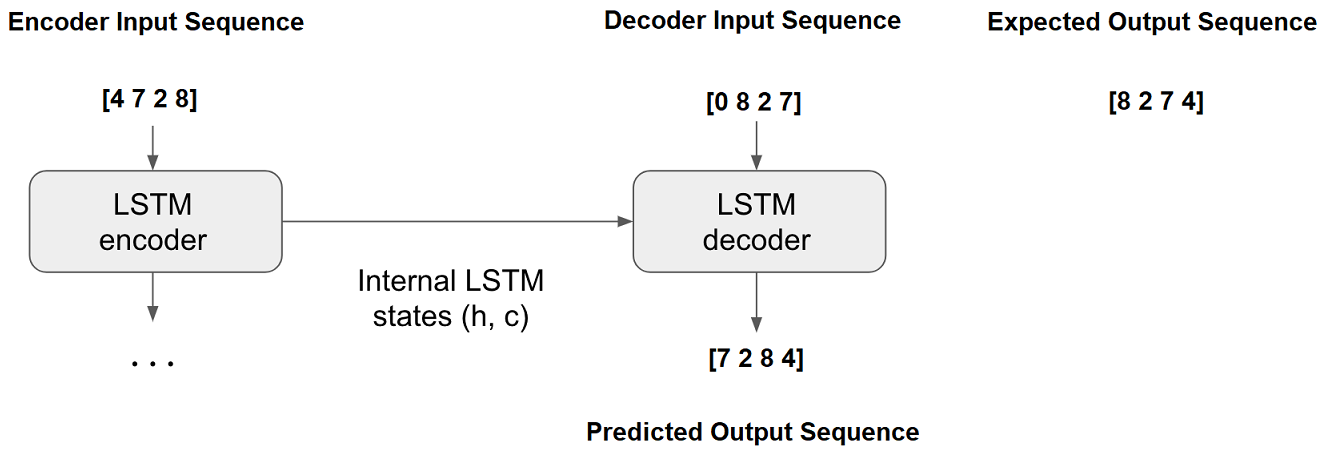

**During training:**
* At the **first** cycle, **decoder** will use encoder's state and its first input which is 0 from ***decoder input sequence*** [0 8 2 7] to generate the first output which is expected to be 8 from [8 2 7 4]
* Assume that decoder predicts ***7***
  * In **generic** Encoder-Decoder model, ***decoder*** will use 7 to generate/predict next token 
  * In **teacher forcing**, we (the teacher!) provide the second input from [0 **8** 2 7] which is **8** to the decoder to generate/predict next token 

Thus,  **during training**,  *teacher* enforces the decoder to condition itself to generate/predict next token according to the **given correct input**!

### HOW TO USE AN ENCODER - DECODER MODEL TRAINED WITH TEACHER FORCING FOR INFERENCE (PREDICTION)

* We need 2 input sequences:
1. Input for encoder: ***encoder_inputs***
2. Input for decoder: ***decoder_inputs***

* The ***encoder_inputs*** is given 
* However, this time we do not have correct outputs
* Therefore,  we will provide the **predicted output** as the input. 
* The first input is '*start*' and the other inputs will be the outputs from previous cycle

#### CREATE AN ENCODER - DECODER MODEL WITH TEACHER FORCING TO TRAIN
* Define the model that will turn `encoder_input_data` & `decoder_input_data` into `decoder_predicted_data`

* complete the decoder model by adding a **Dense** layer with **Softmax** activation function for prediction of the next output
* Dense layer will output **one-hot encoded representation** as we did for input
* Therefore, we will use **n_features** number of neurons


In [ ]:
# TRAINING WITH TEACHER FORCING
# Define an input sequence and process it.
encoder_inputs= Input(shape=(n_timesteps_in, n_features))
encoder_lstm=LSTM(LSTMoutputDimension, return_state=True)
LSTM_outputs, state_h, state_c = encoder_lstm(encoder_inputs)


# We discard `LSTM_outputs` and only keep the other states.
encoder_states = [state_h, state_c]



decoder_inputs = Input(shape=(None, n_features), name='decoder_inputs')
decoder_lstm = LSTM(LSTMoutputDimension, return_sequences=True, return_state=True, name='decoder_lstm')

# Set up the decoder, using `context vector` as initial state.
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

#complete the decoder model by adding a Dense layer with Softmax activation function 
#for prediction of the next output
#Dense layer will output one-hot encoded representation as we did for input
#Therefore, we will use n_features number of neurons
decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# put together
model_encoder_training = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='model_encoder_training')

time: 489 ms


* compile the model

Model: "model_encoder_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 16), (None,  1728        input_8[0][0]                    
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 16), ( 1728        decoder_inputs[0][0]             
                                                                 lstm_3[0][1]

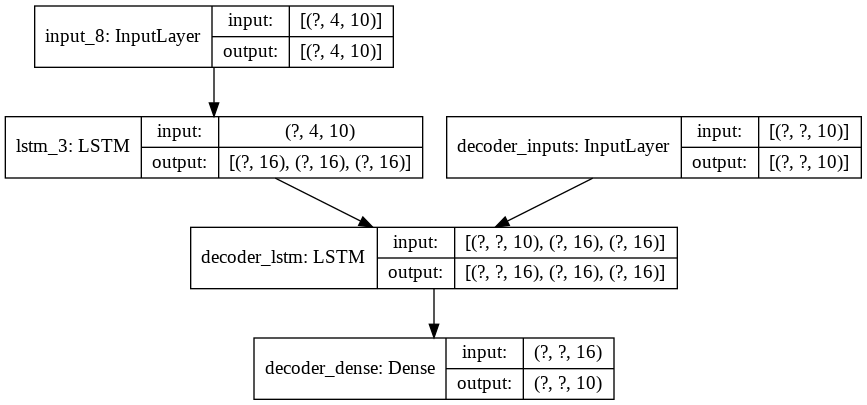

time: 103 ms


In [ ]:
model_encoder_training.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_encoder_training.summary()
plot_model(model_encoder_training, show_shapes=True)

## PREPARE TRAINING DATA SETS
* To train the Encoder Decoder model we need to work on train data set such that we will prepare 3 data sets:

1. Input for encoder (***encoder_inputs***): **all** sequence of 1 sample training input data (X)
2. Input for decoder (***decoder_inputs***): **1** token from 1 sample training target sequence (y) for teacher forcing [should start with '*start*' symbol]
3. Target for decoder (***decoder_predicted_data***): **1** token from 1 sample training target  sequence (y) [should end with '*end*' symbol]


* We can **modify** the code such that the f**irst number (0)** of the input domian numbers are reserved for 'start' and 'end' symbols  as follows:

In [ ]:
#@title Functions to generate Seq2Seq Dataset, one hot encode / decode Input & Output Sequences


# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
  return [argmax(vector) for vector in encoded_seq]

  # prepare encoder data for the Encoder-Decoder training
def get_encoder_triple(time_steps,vocabulary_size,verbose= False):
  # generate random sequence
  sequence_in = generate_sequence(time_steps, vocabulary_size)

  encoder_in = sequence_in.copy()
  

   
  

  decoder_out = sequence_in[::-1]
  
  decoder_in = decoder_out.copy()
  decoder_in.insert(0,0)
  decoder_in.pop()

  # one hot encode
  X_encoder_in = one_hot_encode(encoder_in, vocabulary_size)
  X_decoder_in = one_hot_encode(decoder_in, vocabulary_size)
  y_decoder_out = one_hot_encode(decoder_out, vocabulary_size)
  # reshape as 3D
  X_encoder_in = X_encoder_in.reshape((1, X_encoder_in.shape[0], X_encoder_in.shape[1]))
  X_decoder_in = X_decoder_in.reshape((1, X_decoder_in.shape[0], X_decoder_in.shape[1]))
  y_decoder_out = y_decoder_out.reshape((1, y_decoder_out.shape[0], y_decoder_out.shape[1]))

  if(verbose):
    print('\nSample X_encoder_in X_decoder_in and y_decoder_out')
    print('\nIn raw format:')
    print('X_encoder_in=%s, X_decoder_in=%s, y_decoder_out=%s' % 
          (one_hot_decode(X_encoder_in[0]), one_hot_decode(X_decoder_in[0]), 
           one_hot_decode(y_decoder_out[0])))
    print('\nIn one_hot_encoded format:')
    print('X_encoder_in=%s' % (X_encoder_in[0]))
    print('X_decoder_in=%s' % (X_decoder_in[0]))
    print('y_decoder_out=%s' % (y_decoder_out[0]))
  return [array(X_encoder_in), array(X_decoder_in), array(y_decoder_out)]


def create_encoder_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):

  X_encoder_in = list()
  X_decoder_in = list()
  y_decoder_out = list()

  for _ in range(train_size):
    triple=get_encoder_triple(time_steps,vocabulary_size) 
    X_encoder_in.append(triple[0])
    X_decoder_in.append(triple[1])
    y_decoder_out.append(triple[2])

  X_encoder_in= array(X_encoder_in).squeeze()
  X_decoder_in= array(X_decoder_in).squeeze()
  y_decoder_out= array(y_decoder_out).squeeze()
  if(verbose):
    print('\nGenerated sequence datasets as follows')
    print('X_encoder_in.shape: ', X_encoder_in.shape)
    print('X_decoder_in.shape: ', X_decoder_in.shape)
    print('y_decoder_out.shape: ', y_decoder_out.shape)
    print('Sample sequences in raw format:')
    
    print('X_encoder_in: \n', one_hot_decode(X_encoder_in[0]))
    print('X_decoder_in: \n', one_hot_decode(X_decoder_in[0]))
    print('y_decoder_out: \n',one_hot_decode(y_decoder_out[0]))

    print('Sample sequences in one-hot encoded format:')
    print('X_encoder_in: \n', X_encoder_in[0])
    print('X_decoder_in: \n', X_decoder_in[0])
    print('y_decoder_out: \n', y_decoder_out[0])

  return X_encoder_in,X_decoder_in, y_decoder_out

time: 100 ms


In [ ]:
#@title Configure problem

n_timesteps_in =   4#@param {type:"integer"}
#each input sample has 4 values

n_features = 10   #@param {type:"integer"}
#each value is one_hot_encoded with 10 0/1
#n_timesteps_out = 2  #@param {type:"integer"}
#each output sample has 2 values padded with 0

# generate random sequence
#X,y = get_reversed_pairs(n_timesteps_in,  n_features, verbose=True)
# generate datasets
train_size= 5000 #@param {type:"integer"}
test_size = 100  #@param {type:"integer"}

encoder_input_data, decoder_input_data, decoder_predicted_data=\
create_encoder_dataset(train_size, test_size, n_timesteps_in,n_features , verbose=True)



Generated sequence datasets as follows
X_encoder_in.shape:  (5000, 4, 10)
X_decoder_in.shape:  (5000, 4, 10)
y_decoder_out.shape:  (5000, 4, 10)
Sample sequences in raw format:
X_encoder_in: 
 [8, 8, 9, 3]
X_decoder_in: 
 [0, 3, 9, 8]
y_decoder_out: 
 [3, 9, 8, 8]
Sample sequences in one-hot encoded format:
X_encoder_in: 
 [[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]]
X_decoder_in: 
 [[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]]
y_decoder_out: 
 [[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]]
time: 232 ms


* We train the model while monitoring the loss on a held-out set of 20% of the samples as below.

* However, I prepared a custom `train_test` function for getting a detail report of training and testing.

``` python

# Run training
model_encoder_training.fit([encoder_input_data, decoder_input_data], decoder_predicted_data,
          batch_size=32,
          epochs=50,
          validation_split=0.2)
```



training for  50  epochs begins with EarlyStopping(monitor= val_loss, patience= 5 )....
Epoch 1/50
141/141 - 1s - loss: 2.1932 - accuracy: 0.1816 - val_loss: 1.9553 - val_accuracy: 0.3305
Epoch 2/50
141/141 - 1s - loss: 1.6733 - accuracy: 0.3938 - val_loss: 1.4385 - val_accuracy: 0.4440
Epoch 3/50
141/141 - 1s - loss: 1.2572 - accuracy: 0.5397 - val_loss: 1.0618 - val_accuracy: 0.6390
Epoch 4/50
141/141 - 1s - loss: 0.8866 - accuracy: 0.7571 - val_loss: 0.7176 - val_accuracy: 0.8450
Epoch 5/50
141/141 - 1s - loss: 0.5942 - accuracy: 0.9013 - val_loss: 0.4837 - val_accuracy: 0.9325
Epoch 6/50
141/141 - 1s - loss: 0.4066 - accuracy: 0.9533 - val_loss: 0.3380 - val_accuracy: 0.9650
Epoch 7/50
141/141 - 1s - loss: 0.2922 - accuracy: 0.9738 - val_loss: 0.2490 - val_accuracy: 0.9760
Epoch 8/50
141/141 - 1s - loss: 0.2196 - accuracy: 0.9853 - val_loss: 0.1905 - val_accuracy: 0.9865
Epoch 9/50
141/141 - 1s - loss: 0.1698 - accuracy: 0.9912 - val_loss: 0.1498 - val_accuracy: 0.9915
Epoch 10/50


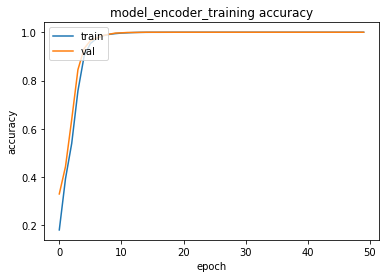

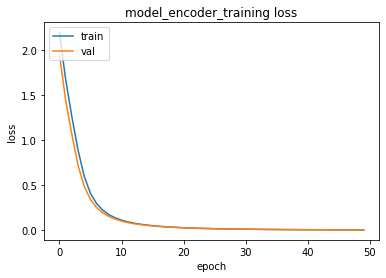

10 examples from test data...
Input          Expected       Predicted         T/F
[8, 8, 9, 3]   [3, 9, 8, 8]   [3, 9, 8, 8]   True
[1, 7, 5, 9]   [9, 5, 7, 1]   [9, 5, 7, 1]   True
[3, 5, 6, 5]   [5, 6, 5, 3]   [5, 6, 5, 3]   True
[2, 3, 3, 9]   [9, 3, 3, 2]   [9, 3, 3, 2]   True
[5, 4, 3, 5]   [5, 3, 4, 5]   [5, 3, 4, 5]   True
[4, 2, 1, 5]   [5, 1, 2, 4]   [5, 1, 2, 4]   True
[9, 5, 2, 4]   [4, 2, 5, 9]   [4, 2, 5, 9]   True
[9, 8, 5, 5]   [5, 5, 8, 9]   [5, 5, 8, 9]   True
[2, 9, 9, 7]   [7, 9, 9, 2]   [7, 9, 9, 2]   True
[7, 2, 9, 8]   [8, 9, 2, 7]   [8, 9, 2, 7]   True
Accuracy:  1.0
time: 37.2 s


In [ ]:
train_test(model_encoder_training, [encoder_input_data, decoder_input_data], decoder_predicted_data , [encoder_input_data, decoder_input_data], decoder_predicted_data, epochs=50, batch_size=32, patience=5,verbose=2)

* We observed that training is finalized almost 100% accuarcy with validation training sets

**IMPORTANT: Please note that we execute *validation* and *testing* by just using the training data and Teacher Forcing in place!!!**

* WHY?

**Because**:
* Teacher Forcing needs to know the correct output beforehand
* Teacher Forcing is a method for improvig training process
* The model employing Teacher Forcing CAN NOT BE USED in inference/testing

**Therefore**, 

* the model that we trained above CAN NOT BE DIRECTLY USED in inference/testing
* We will use some layers (with their weights) of the trained model to create a new model
* The new model will not use Teacher Learning
* Thus, the input to the new model will NOT BE  `[encoder_input_data, decoder_input_data]` as the way we designed in `model_encoder_training`
* **Remember**, in Teacher Forcing, we set `decoder_input_data` such that it begins with a special symbol `start` and continues with the target sequence data except the last time step.
* Now, during inference (testing), we do not know the correct (expected) target data before hand!
* We define the `decoder_input_data` as follows:
  * it begins with a special symbol `start`
  * it will continue with an input created by the decoder at previous time step
  * in other words, **decoder's output at time step t** will be used **decoder's input at time step t+1**



# Let's begin to design encoder-decoder model for inference


## We create **a seperate encoder model** by using the **trained layers** in above model

**IMPORTANT**: pay attention that in this model we use `encoder_inputs, encoder_states` for encoding which are parts of the encoder model we trained above. That is, this layers come with its **trained weights **with Teacher Forcing 

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

time: 11 ms


## Then we create **a seperate decoder model** by using the **trained layers** in above model

* Design the decoder model by defining layers for:
  * inputs
  * decoding (LSTM)
  * outputs

**IMPORTANT**: pay attention that in this model we use `decoder_lstm` for decoding which is a part of the decoder model we trained above. That is this layer comes with its **trained weights** with Teacher Forcing 

In [ ]:
decoder_state_input_h = Input(shape=(LSTMoutputDimension,))
decoder_state_input_c = Input(shape=(LSTMoutputDimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

time: 237 ms


* Even though we define the encoder and decoder models we still need to dynamically provide the `decoder_input_data` as follows:
  * it begins with a special symbol `start`
  * it will continue with an input created by the decoder at previous time step
  * in other words, **decoder's output at time step t** will be used **decoder's input at time step t+1**

* Let's code it as a function:

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_features))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_digit = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_digit)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_digit == '\n' or
           len(decoded_seq) == n_timesteps_in):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq = np.zeros((1, 1, n_features))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq

time: 22.4 ms


## We can now put encoder model and decoder model together by using the function above for inference as below.

**IMPORTANT**: 
* Since we used the trained layers in here we do NOT need to train recently created models.
* We only provide the input sequence to the function.

In [ ]:
print('Input \t\t\t  Expected  \t   Predicted \t\tT/F')
correct =0 
sampleNo =  10
for sample in range(0,sampleNo):
  predicted= decode_sequence(encoder_input_data[sample].reshape(1,n_timesteps_in,n_features))
  if (one_hot_decode(decoder_predicted_data[sample])== predicted):
    correct+=1
  print( one_hot_decode(encoder_input_data[sample]), '\t\t', 
        one_hot_decode(decoder_predicted_data[sample]),'\t', predicted,
        '\t\t',one_hot_decode(decoder_predicted_data[sample])== predicted)
print('Accuracy: ', correct/sampleNo)

Input 			  Expected  	   Predicted 		T/F
[8, 8, 9, 3] 		 [3, 9, 8, 8] 	 [3, 9, 8, 8] 		 True
[1, 7, 5, 9] 		 [9, 5, 7, 1] 	 [9, 5, 7, 1] 		 True
[3, 5, 6, 5] 		 [5, 6, 5, 3] 	 [5, 6, 5, 3] 		 True
[2, 3, 3, 9] 		 [9, 3, 3, 2] 	 [9, 3, 3, 2] 		 True
[5, 4, 3, 5] 		 [5, 3, 4, 5] 	 [5, 3, 4, 5] 		 True
[4, 2, 1, 5] 		 [5, 1, 2, 4] 	 [5, 1, 2, 4] 		 True
[9, 5, 2, 4] 		 [4, 2, 5, 9] 	 [4, 2, 5, 9] 		 True
[9, 8, 5, 5] 		 [5, 5, 8, 9] 	 [5, 5, 8, 9] 		 True
[2, 9, 9, 7] 		 [7, 9, 9, 2] 	 [7, 9, 9, 2] 		 True
[7, 2, 9, 8] 		 [8, 9, 2, 7] 	 [8, 9, 2, 7] 		 True
Accuracy:  1.0
time: 1.96 s


# Observations:
* Teacher Forcing is a method to train encoder-decoder models in Seq2Seq model to **accelerate training**
* Teacher Forcing can **ONLY** be used at Training
* We need to handle how to use the model in **inference**
* **Even though Teacher Forcing improves the training process by fast converging, in the inference the model can generate low accuracy even with the training data.**
* Therefore, you need to use Teacher Forcing with caution

# What if I don't want to use teacher forcing for training?

* Please look at **the previous part** how to implement an Encoder-Decoder without Teacher Forcing training:



# NEXT:
# Part E: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL FOR VARIABLE INPUT AND OUTPUT SIZE